In [16]:
# !pip install xgboost

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

df = pd.read_csv('C:/Users/huseynovi/Desktop/Remote/Superstore/Superstore.csv', encoding='latin1')

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11-08-16,11-11-16,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11-08-16,11-11-16,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,06-12-16,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10-11-15,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10-11-15,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [18]:
df.info()

print(df.columns)

print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

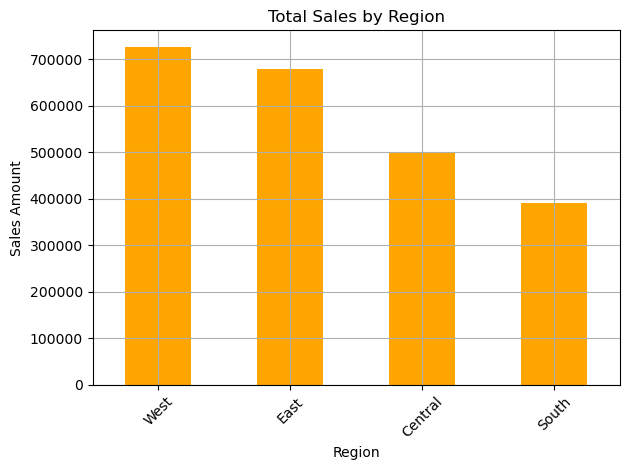

In [19]:
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)

region_sales.plot(kind='bar', title='Total Sales by Region', color='orange')
plt.ylabel('Sales Amount')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

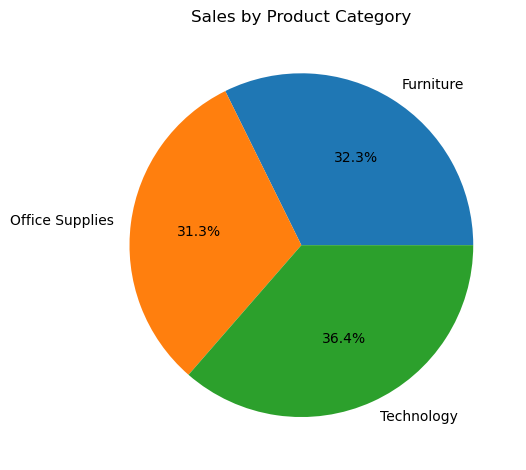

In [20]:
category_sales = df.groupby('Category')['Sales'].sum()

category_sales.plot(kind='pie', autopct='%1.1f%%', title='Sales by Product Category')
plt.ylabel('')
plt.tight_layout()
plt.show()

C:\Users\huseynovi\AppData\Local\Temp\ipykernel_13740\3603308998.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



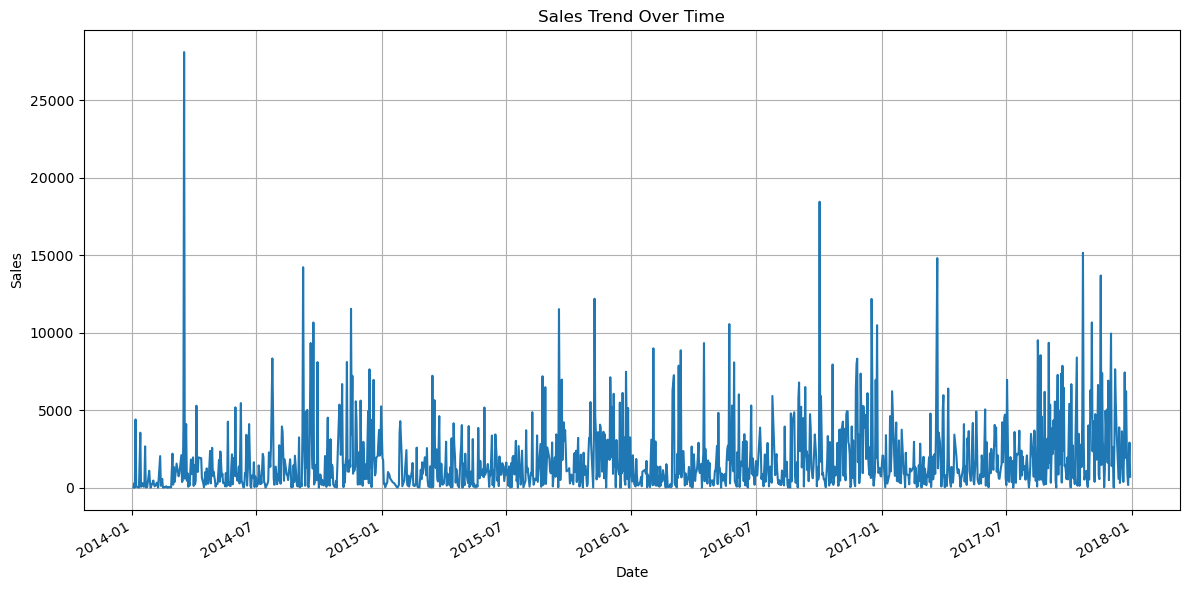

In [21]:
# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Group sales by date
time_series = df.groupby('Order Date')['Sales'].sum()

# Plot time series
plt.figure(figsize=(12, 6))
time_series.plot(title='Sales Trend Over Time')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\huseynovi\AppData\Local\Temp\ipykernel_13740\900464636.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



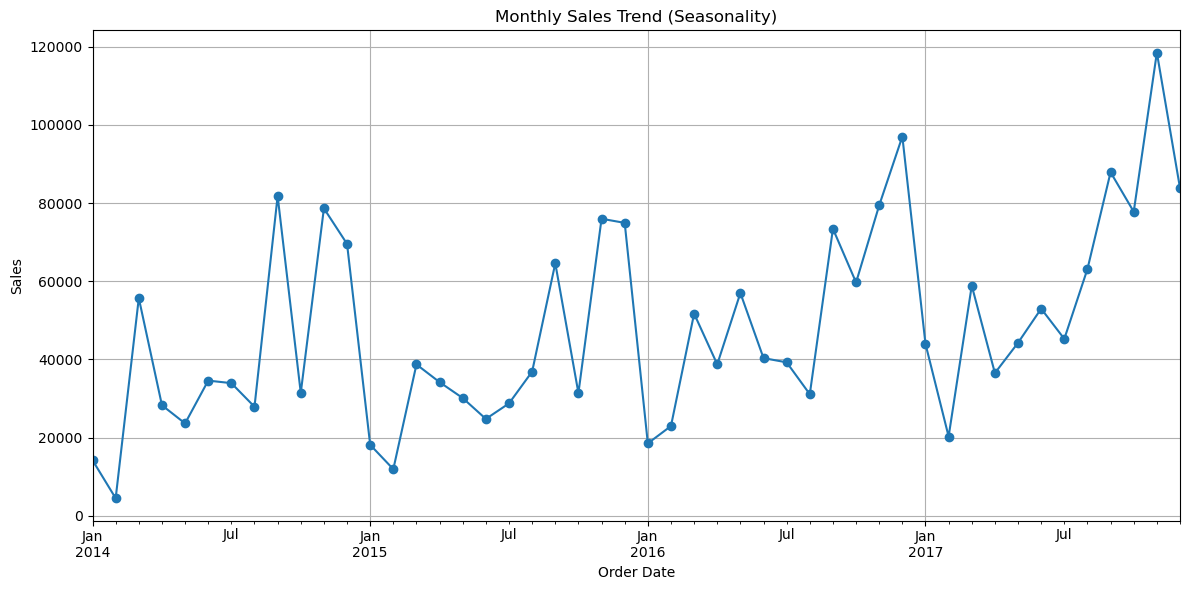

In [22]:
# Monthly total sales
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o', title='Monthly Sales Trend (Seasonality)')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
df['Sub-Category'].unique()

array(['Bookcases', 'Chairs', 'Labels', 'Tables', 'Storage',
       'Furnishings', 'Art', 'Phones', 'Binders', 'Appliances', 'Paper',
       'Accessories', 'Envelopes', 'Fasteners', 'Supplies', 'Machines',
       'Copiers'], dtype=object)

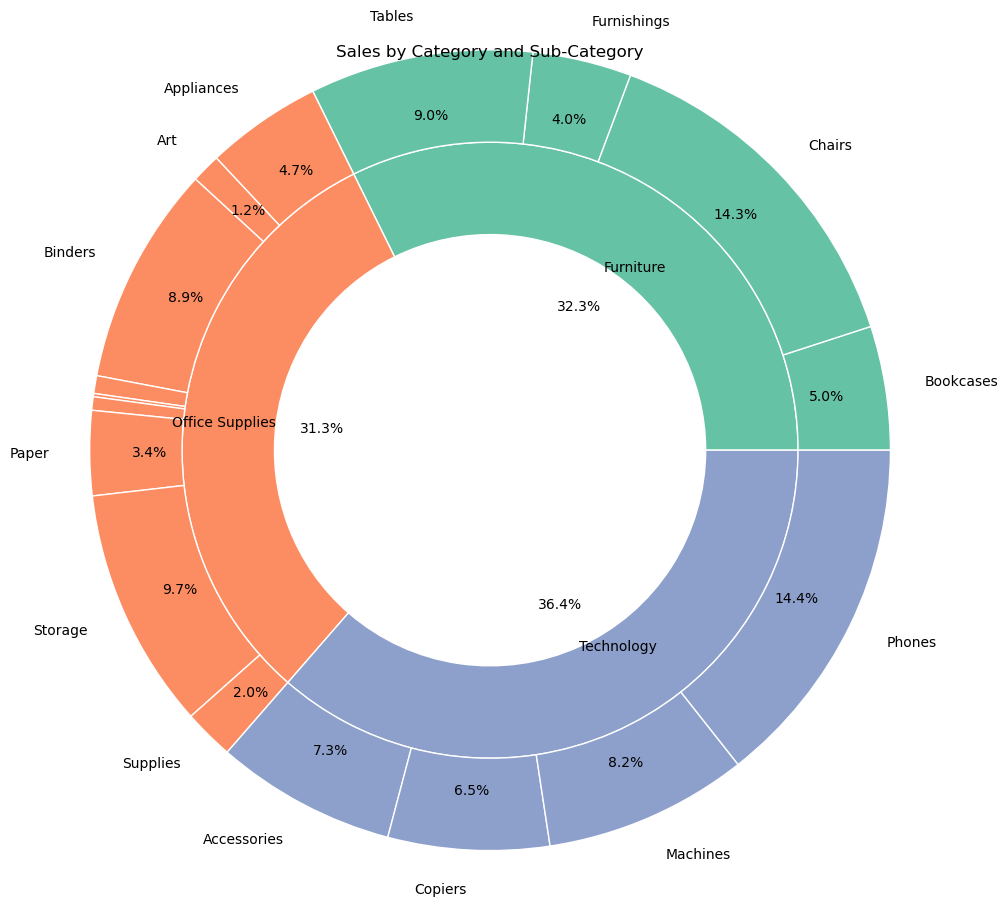


Sub-categories below 1% of total sales:
Sub-Category Percent
   Envelopes   0.72%
      Labels   0.54%
   Fasteners   0.13%


In [24]:
import plotly.graph_objects as go
grouped = df.groupby(['Category', 'Sub-Category'])['Sales'].sum().reset_index()
total_sales = grouped['Sales'].sum()
grouped['Percent'] = grouped['Sales'] / total_sales * 100

category_sales = grouped.groupby('Category')['Sales'].sum()
sub_labels = grouped['Sub-Category']
sub_sizes = grouped['Sales']
sub_parents = grouped['Category']

category_colors = plt.cm.Set2.colors[:len(category_sales)]
category_color_map = dict(zip(category_sales.index, category_colors))
sub_colors = [category_color_map[parent] for parent in sub_parents]

fig, ax = plt.subplots(figsize=(10, 10))

ax.pie(
    category_sales,
    radius=1,
    labels=category_sales.index,
    labeldistance=0.7,
    colors=[category_color_map[c] for c in category_sales.index],
    wedgeprops=dict(width=0.3, edgecolor='white'),
    autopct='%1.1f%%',
    pctdistance=0.55
)

def label_or_blank(p, label):
    return label if p >= 1 else ''

def percent_or_blank(p):
    return f'{p:.1f}%' if p >= 1 else ''

labels_filtered = [label_or_blank(p, label) for p, label in zip(grouped['Percent'], sub_labels)]
autopcts = [percent_or_blank(p) for p in grouped['Percent']]

ax.pie(
    sub_sizes,
    radius=1.3,
    labels=labels_filtered,
    labeldistance=1.1,
    colors=sub_colors,
    wedgeprops=dict(width=0.3, edgecolor='white'),
    autopct=lambda p: f'{p:.1f}%' if p >= 1 else '',
    pctdistance=0.85
)

ax.set(aspect="equal", title='Sales by Category and Sub-Category')

low_pct = grouped[grouped['Percent'] < 1][['Sub-Category', 'Percent']].sort_values(by='Percent', ascending=False)

plt.show()

print('\nSub-categories below 1% of total sales:')
print(low_pct.to_string(index=False, formatters={'Percent': '{:.2f}%'.format}))

In [25]:
grouped = df.groupby(['Category', 'Region', 'Segment'])['Sales'].sum().reset_index()

all_labels = pd.unique(grouped[['Category', 'Region', 'Segment']].values.ravel())
label_to_index = {label: i for i, label in enumerate(all_labels)}

source = []
target = []
value = []

# Category → Region
for _, row in grouped.iterrows():
    category = row['Category']
    region = row['Region']
    segment = row['Segment']
    sales = row['Sales']

    source.append(label_to_index[category])
    target.append(label_to_index[region])
    value.append(sales)

    source.append(label_to_index[region])
    target.append(label_to_index[segment])
    value.append(sales)


fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(label_to_index.keys()),
        color="blue"
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="Sales Flow: Category → Region → Segment", font_size=12)
fig.show()

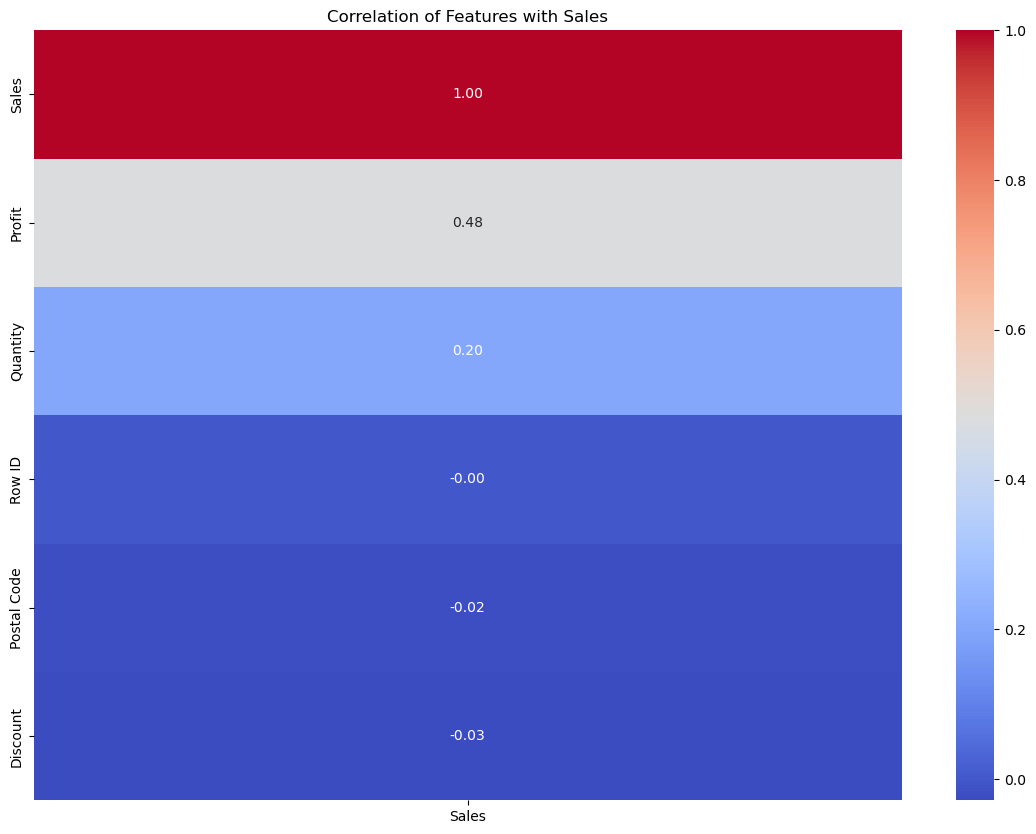

In [26]:
plt.figure(figsize=(14, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['Sales']].sort_values(by='Sales', ascending=False), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Features with Sales')
plt.show()

# Separate features and target
X = df.drop('Sales', axis=1)
y = df['Sales']

In [27]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

drop_cols = ['Order ID', 'Customer Name', 'Order Date', 'Ship Date', 'Product ID', 'Customer ID']
df.drop([col for col in drop_cols if col in df.columns], axis=1, inplace=True)

# Feature Engineering
if all(col in df.columns for col in ['Sales', 'Quantity']):
    df['Sales_per_Quantity'] = df['Sales'] / (df['Quantity'] + 1e-5)

if all(col in df.columns for col in ['Sales', 'Discount']):
    df['Sales_per_Discount'] = df['Sales'] / (df['Discount'] + 1e-5)

# One-hot Encoding
df = pd.get_dummies(df, drop_first=True)

# Log Transform Target
df['Sales'] = np.log1p(df['Sales'])

# Split Features and Target
X = df.drop('Sales', axis=1)
y = df['Sales']

# Standardize Features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# PCA (keep 90% of variance)
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# ----------------------
# Models
# ----------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# ----------------------
# Evaluation Function
# ----------------------
def print_results(model_name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} RMSE: {rmse:.4f}")
    print(f"{model_name} R²: {r2:.4f}\n")

# ----------------------
# Results
# ----------------------
print("PCA Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance (PCA):", sum(pca.explained_variance_ratio_))
print()

print_results("Linear Regression", y_test, y_pred_lr)
print_results("Random Forest", y_test, y_pred_rf)
print_results("XGBoost", y_test, y_pred_xgb)

🔍 PCA Explained Variance Ratio: [0.00190973 0.00159445 0.00140614 ... 0.00029756 0.00029735 0.00029695]
📊 Total Explained Variance (PCA): 0.9001043650515838

Linear Regression RMSE: 15.2341
Linear Regression R²: -90.1122

Random Forest RMSE: 0.7609
Random Forest R²: 0.7727

XGBoost RMSE: 0.6579
XGBoost R²: 0.8301



In [28]:
def predict_new_data(new_data_df, scaler, pca, model):
    
    
    if all(col in new_data_df.columns for col in ['Sales', 'Quantity']):
        new_data_df['Sales_per_Quantity'] = new_data_df['Sales'] / (new_data_df['Quantity'] + 1e-5)

    if all(col in new_data_df.columns for col in ['Sales', 'Discount']):
        new_data_df['Sales_per_Discount'] = new_data_df['Sales'] / (new_data_df['Discount'] + 1e-5)

    
    if 'Sales' in new_data_df.columns:
        new_data_df = new_data_df.drop('Sales', axis=1)

    # One-hot encoding 
    new_data_df = pd.get_dummies(new_data_df, drop_first=True)

    
    for col in X.columns:
        if col not in new_data_df.columns:
            new_data_df[col] = 0
    new_data_df = new_data_df[X.columns]  # sütunların sırası da eyni olmalı

    # Scale
    new_scaled = scaler.transform(new_data_df)

    # PCA
    new_pca = pca.transform(new_scaled)

    # Predict (log formatında olacaq)
    log_sales_pred = model.predict(new_pca)

    # Geri transformasiya (log -> real sales)
    sales_pred = np.expm1(log_sales_pred)

    return sales_pred


C:\Users\huseynovi\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



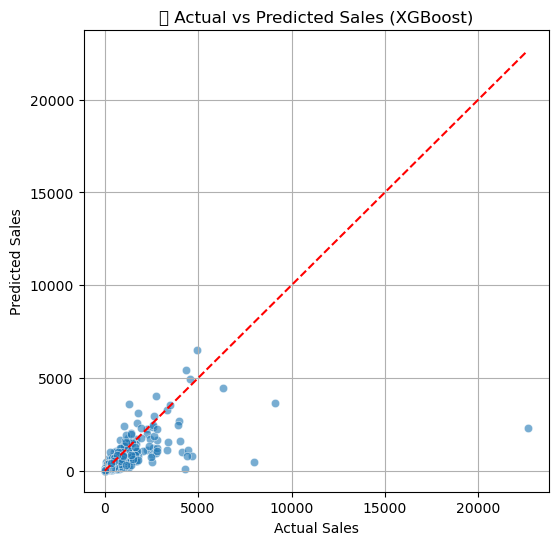

C:\Users\huseynovi\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



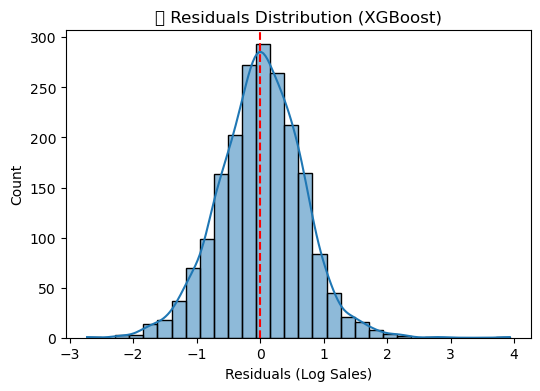

In [30]:
# ----------- Prediction vs Actual ----------
plt.figure(figsize=(6, 6))
sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_pred_xgb), alpha=0.6)
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], color='red', linestyle='--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (XGBoost)")
plt.grid(True)
plt.show()

# ----------- Residual Plot ----------
residuals = y_test - y_pred_xgb
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution (XGBoost)")
plt.xlabel("Residuals (Log Sales)")
plt.show()


In [35]:

new_data = pd.DataFrame({
    'Region': ['Central'],
    'Category': ['Furniture'],
    'Sub-Category': ['Chairs'],
    'Discount': [0.1],
    'Quantity': [3],
    'Shipping Cost': [25],
    'Sales': [500],  
})

predicted_sales = predict_new_data(new_data, scaler, pca, xgb)
print("Predicted Sales:", predicted_sales)


C:\Users\huseynovi\AppData\Local\Temp\ipykernel_13740\3518639046.py:22: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\huseynovi\AppData\Local\Temp\ipykernel_13740\3518639046.py:22: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\huseynovi\AppData\Local\Temp\ipykernel_13740\3518639046.py:22: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

Predicted Sales: [203.12036]


C:\Users\huseynovi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [34]:
def predict_sales():
    
    region = input("Region (Central, East, South, West): ")
    category = input("Category (Furniture, Office Supplies, Technology): ")
    subcat = input("Sub-Category (Chairs, Phones, etc.): ")
    discount = float(input("Discount (0.0 - 0.9): "))
    quantity = int(input("Quantity: "))
    ship_cost = float(input("Shipping Cost: "))

    inp = pd.DataFrame([{
        'Region': region,
        'Category': category,
        'Sub-Category': subcat,
        'Discount': discount,
        'Quantity': quantity,
        'Shipping Cost': ship_cost,
        'Sales_per_Quantity': 0,
        'Sales_per_Discount': 0
    }])

        inp = pd.get_dummies(inp, drop_first=True)
    for col in X.columns:
        if col not in inp.columns:
            inp[col] = 0
    inp = inp[X.columns]

   
    inp_scaled = scaler.transform(inp)
    inp_pca = pca.transform(inp_scaled)
    log_pred = xgb.predict(inp_pca)
    sale = np.expm1(log_pred[0])

    print(f"\n💰 Sales predict: {sale:.2f} AZN")


predict_sales()


IndentationError: unexpected indent (2880711113.py, line 10)